# Example: Variational Auto-Encoder

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [7]:
pokemon = datasets.ImageFolder("../datasets/pokemon")
transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
pokemon.transform = transformer

train, test, val = torch.utils.data.random_split(pokemon, (0.8, 0.1, 0.1))

len(train), len(test), len(val)

(32478, 4060, 4059)

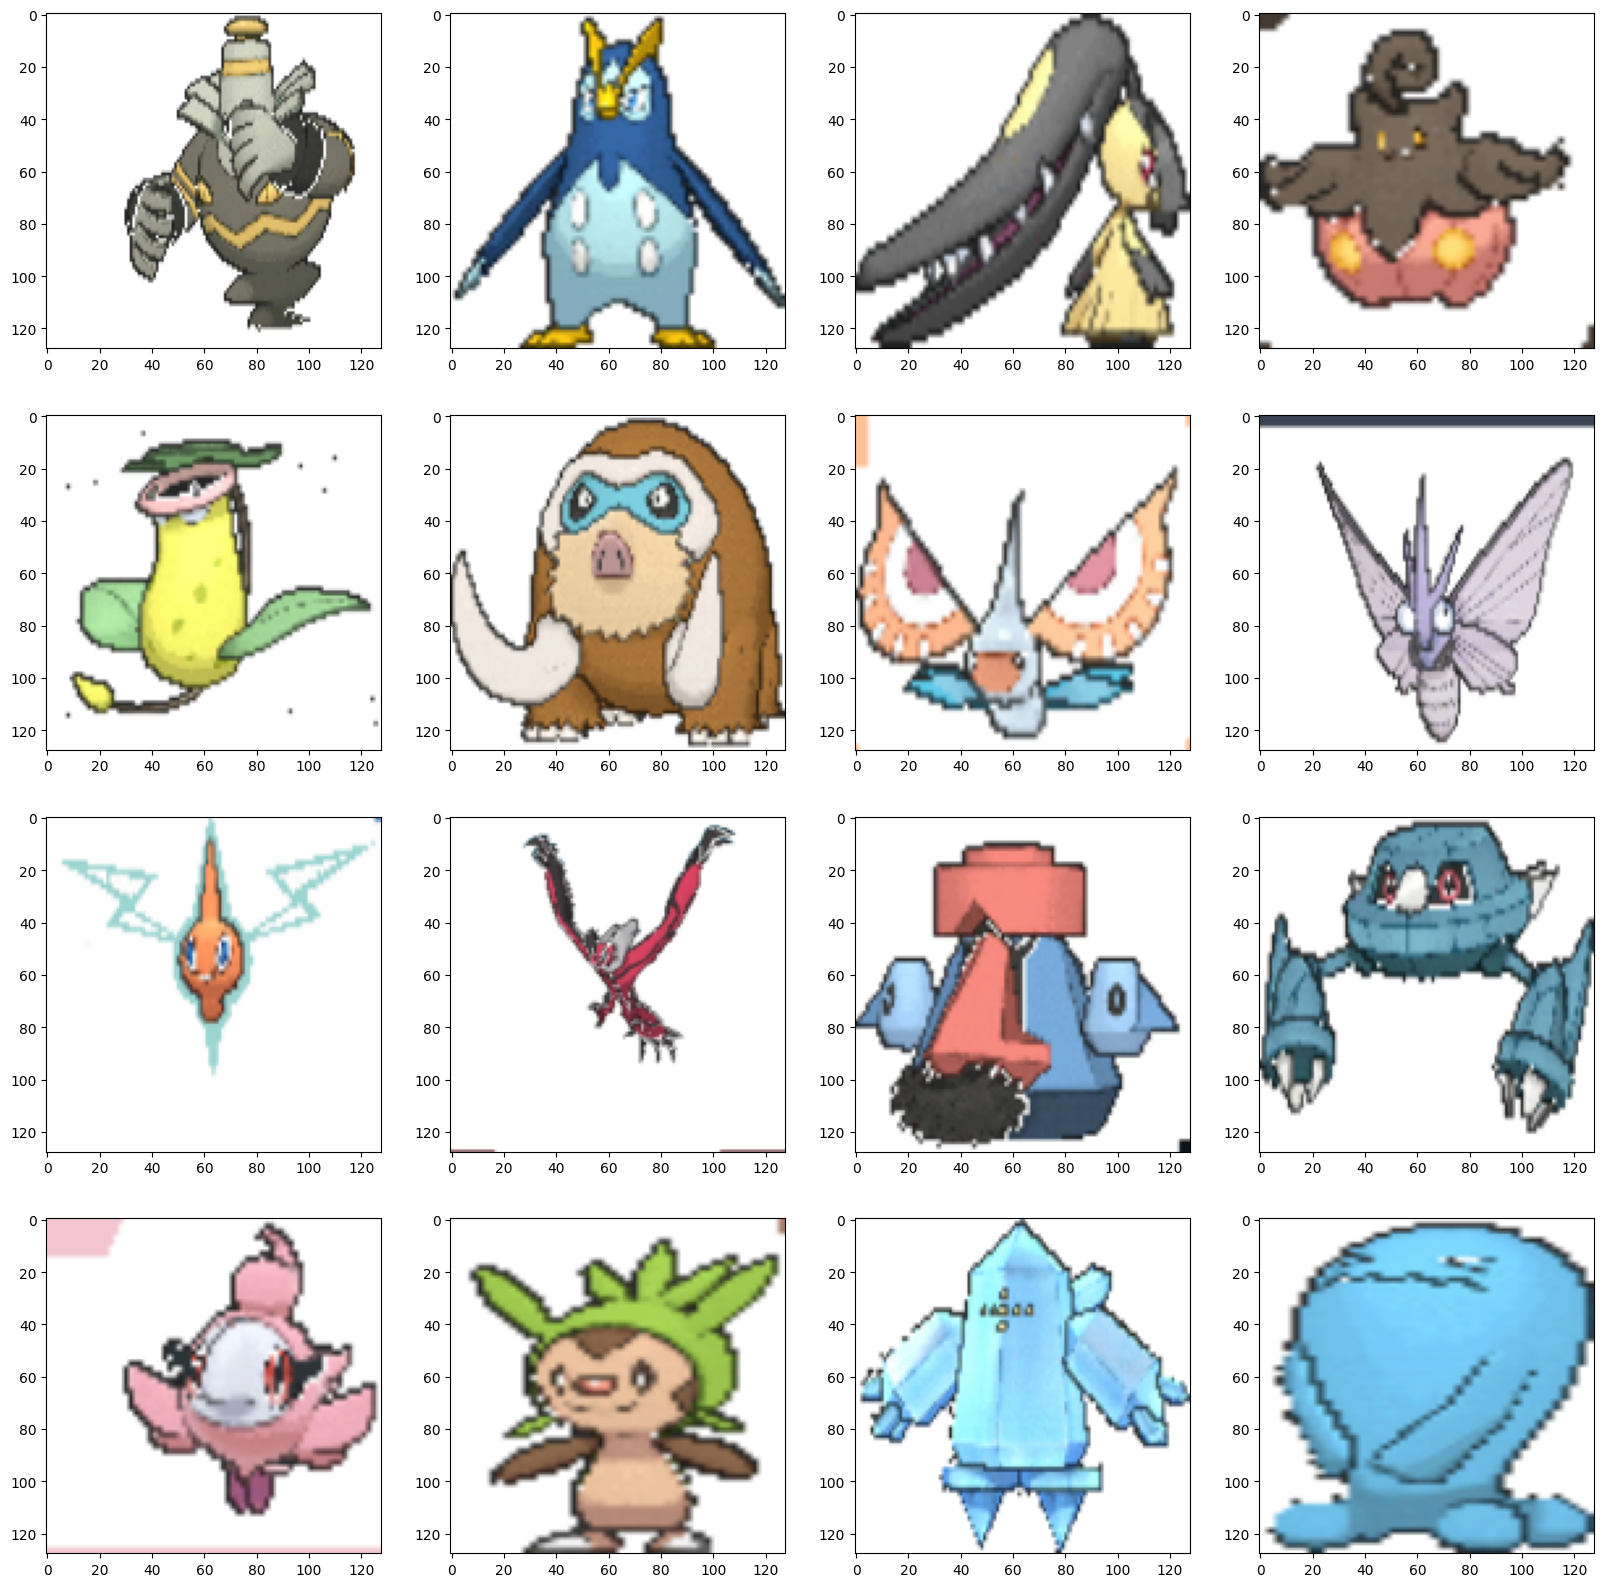

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

data_iter = torch.utils.data.DataLoader(pokemon, batch_size=32, shuffle=True)
for X, y in data_iter:
    img = X[:20, :, :, :].permute(0, 2, 3, 1)
    for i, ax in enumerate(axes):
        ax.imshow(img[i])
    break

## Variational Auto-Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 128 -> 64
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 16
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 8
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 4
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 1
            nn.Conv2d(512, z_size, kernel_size=3, stride=2, padding=0, bias=False),
        )
    
    def forward(self, X: torch.Tensor):
        return self.net(X)

class Decoder(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.net = nn.Sequential(
            # 1 -> 4
            nn.ConvTranspose2d(z_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, affine=True),
            nn.ReLU(inplace=True),
            # 4 -> 8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=True),
            nn.ReLU(inplace=True),
            # 8 -> 16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            # 16 -> 32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 32 -> 64
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            # 64 -> 128
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, X: torch.Tensor):
        return self.net(X)
    
enc = Encoder(2)
dec = Decoder(2)
x = torch.randn(16, 3, 128, 128)
enc(x).shape, dec(enc(x)).shape

(torch.Size([16, 2, 1, 1]), torch.Size([16, 3, 128, 128]))

In [22]:
class VAE(nn.Module):
    def __init__(self, z_size=2):
        super().__init__()
        self.z_size = z_size
        self.enc = Encoder(2*z_size)
        self.dec = Decoder(z_size)
    
    def encode(self, X: torch.Tensor):
        h = self.enc(X) # (batch_size, 2*z_dim, 1, 1)
        mu = h[:, :self.z_size].view(-1, self.z_size)       # mean vec mu: (batch_size, z_dim)
        log_var = h[:, self.z_size:].view(-1, self.z_size)  # log variance:(batch_size, z_dim)
        return mu, log_var
    
    def decode(self, mu: torch.Tensor, log_var: torch.Tensor):
        eps = torch.randn(mu.shape[0], self.z_size).to(mu.device) # random eps \sim N(0, I)
        z = mu + torch.exp(0.5 * log_var) * eps
        z = z.reshape(*z.shape, 1, 1) # (batch_size, z_dim, 1, 1)
        y = self.dec(z)
        return y, z
    
    def forward(self, X: torch.Tensor):
        mu, log_var = self.encode(X)
        y, z = self.decode(mu, log_var)
        return y, z, mu, log_var
    
x = torch.randn(16, 3, 128, 128)
g = VAE(z_size=2)
y, z, mu, log_var = g(x)
y.shape, z.shape, mu.shape, log_var.shape

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 2, 1, 1]),
 torch.Size([16, 2]),
 torch.Size([16, 2]))

## Training procedure

In [23]:
EPOCHS = 20
Z_SIZE = 200
BATCH_SIZE = 256
lambda_rec_error = 1000

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)

generator = VAE(z_size=Z_SIZE).to('cuda')

optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.BCEWithLogitsLoss()

train_history = []
val_history = []

In [24]:
for epoch in range(EPOCHS):
    batch_history = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to('cuda')
        # predict and compute loss
        preds, _, mu, log_var = generator(images)
        
        # loss is reconstruction error + kl regularization term
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        loss = rec_error + kl_reg
        
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # update learning rate
    scheduler.step()
    
    train_history.append(torch.mean(torch.tensor(batch_history)))
    
    batch_history = []
    with torch.no_grad():
        for i, (images, _) in enumerate(val_loader):
            images = images.to('cuda')
            preds, _, mu, log_var = generator(images)
            kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
            rec_error = lambda_rec_error * criterion(preds, images)
            loss = rec_error + kl_reg
            batch_history.append(loss.item())
        val_history.append(torch.mean(torch.tensor(batch_history)))
        
    print(f"epoch {epoch}, train_loss {train_history[-1]}, val_loss {val_history[-1]}")

with torch.no_grad():
    test_loss = 0
    for i, (images, _) in enumerate(test_loader):
        images = images.to('cuda')
        preds, _, mu, log_var = generator(images)
        kl_reg = torch.mean(- 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
        rec_error = lambda_rec_error * criterion(preds, images)
        test_loss += (rec_error + kl_reg).item()
    print(f"test loss = {test_loss / len(test_loader)}")

C:\Users\janba\python-dev\deeplearning_notebooks\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch 0, train_loss 503.49334716796875, val_loss 463.7750549316406
epoch 1, train_loss 454.2710876464844, val_loss 447.9964599609375
epoch 2, train_loss 443.51068115234375, val_loss 440.4974060058594
epoch 3, train_loss 436.6827697753906, val_loss 435.3108825683594
epoch 4, train_loss 431.7867736816406, val_loss 430.86651611328125
epoch 5, train_loss 427.5878601074219, val_loss 426.734619140625
epoch 6, train_loss 423.1599426269531, val_loss 421.6581115722656
epoch 7, train_loss 418.5098876953125, val_loss 417.9112854003906
epoch 8, train_loss 414.5132141113281, val_loss 413.8798522949219
epoch 9, train_loss 410.6843566894531, val_loss 410.6894226074219
epoch 10, train_loss 407.30364990234375, val_loss 407.4836730957031
epoch 11, train_loss 404.23870849609375, val_loss 404.904052734375
epoch 12, train_loss 401.32049560546875, val_loss 402.36279296875
epoch 13, train_loss 398.8336486816406, val_loss 399.4241943359375
epoch 14, train_loss 396.53436279296875, val_loss 397.7568054199219
ep

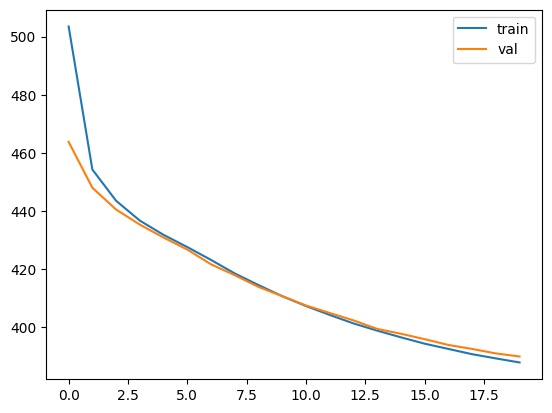

In [25]:
plt.plot(train_history, label="train")
plt.plot(val_history, label="val")
plt.legend()

## encoding decoding specific pokemon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


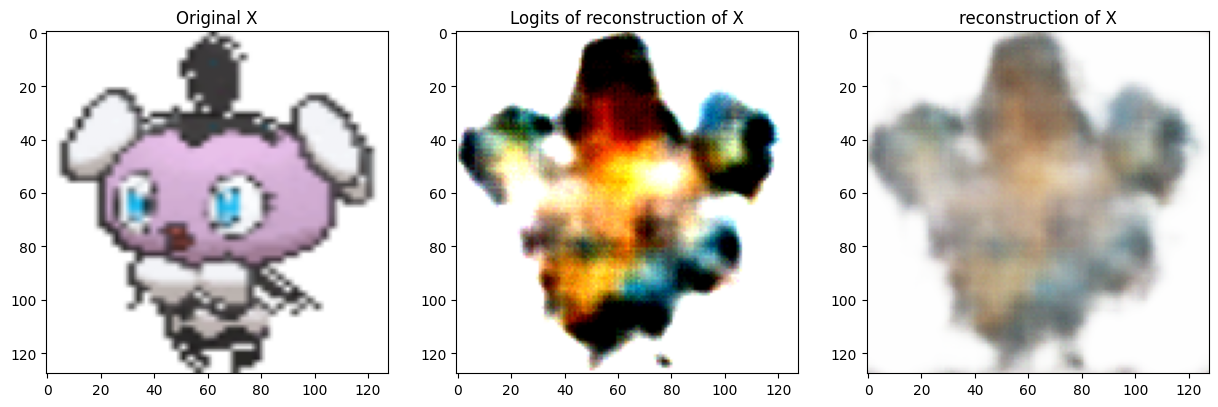

In [30]:
from itertools import islice

data_iter = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

idx = 172
X_sample, _ = next(islice(data_iter, idx, idx+1))
X_sample = X_sample[:1].to('cuda')

y_pred, _, _, _ = generator(X_sample)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(X_sample.cpu().squeeze().permute(1, 2, 0), cmap='gray')
ax1.set_title("Original X")

ax2.imshow(y_pred.cpu().squeeze().detach().permute(1, 2, 0), cmap='gray')
ax2.set_title("Logits of reconstruction of X")

ax3.imshow(F.sigmoid(y_pred).cpu().squeeze().detach().permute(1, 2, 0), cmap='gray')
ax3.set_title("reconstruction of X")

plt.show()

## Sampling on the $z$-dimension manifold

In [36]:
h, w = 20, 20
z1_range = torch.linspace(-10, 10, h)
z2_range = torch.linspace(-10, 10, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()
y_preds = (y_preds                      # (h*w, 3, 64, 64)
           .permute(1, 0, 2, 3)         # (3, h*w, 64, 64)
           .reshape(3, h, w, 64, 64)    # (3, h, w, 64, 64)
           .permute(0, 1, 3, 2, 4)      # (3, h, 64, w, 64)
           .reshape(3, h*64, w*64)      # (3, h*64, w*64)
           .permute(1, 2, 0))           # (h*64, w*64, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.show()

# plt.savefig("../images/manifolds/faces.svg", dpi=300)

RuntimeError: Given transposed=1, weight of size [200, 512, 4, 4], expected input[400, 2, 1, 1] to have 200 channels, but got 2 channels instead

## Sampling manifold at random when $z > 2$

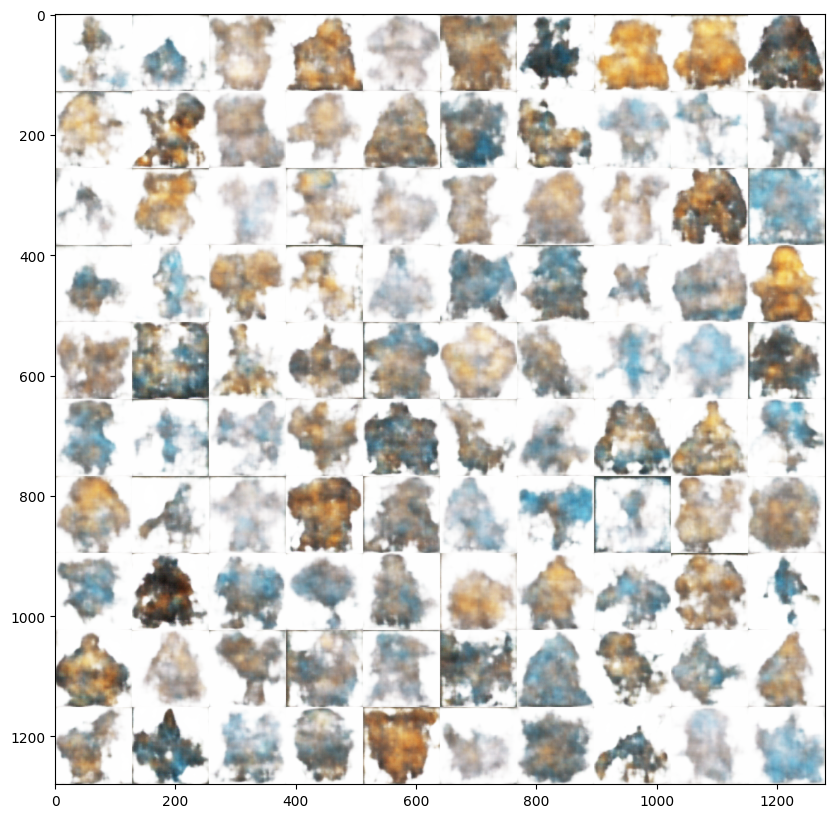

In [37]:
d = 128
h, w = 10, 10
z_vecs = torch.randn(h*w, Z_SIZE, 1, 1).to('cuda')

y_preds = F.sigmoid(generator.dec(z_vecs)).squeeze().cpu().detach()
y_preds = (y_preds                      # (h*w, 3, d, d)
           .permute(1, 0, 2, 3)         # (3, h*w, d, d)
           .reshape(3, h, w, d, d)      # (3, h, w, d, d)
           .permute(0, 1, 3, 2, 4)      # (3, h, d, w, d)
           .reshape(3, h*d, w*d)        # (3, h*d, w*d)
           .permute(1, 2, 0))           # (h*d, w*d, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds, cmap='gray')

plt.savefig("../images/manifolds/pokemon0.svg", dpi=300)

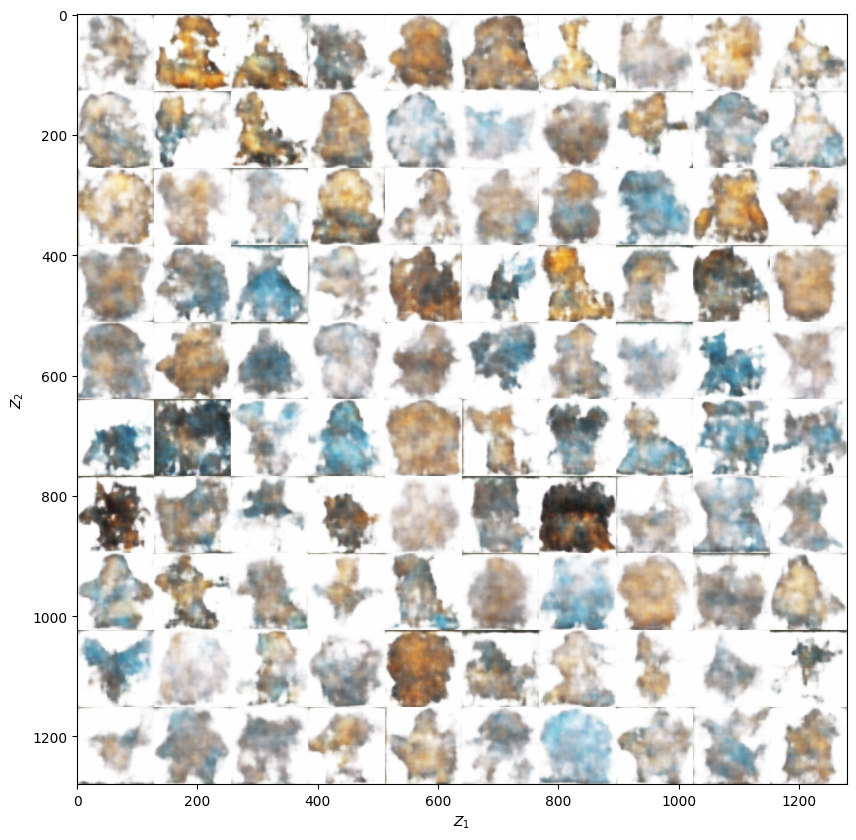

In [35]:
z1_range = torch.linspace(-10, 10, h)
z2_range = torch.linspace(-10, 10, w)

z1, z2 = torch.meshgrid(z1_range, z2_range)
zz = torch.stack([z1, z2], dim=-1).reshape(-1, 2, 1, 1).to('cuda')
zz = torch.cat([zz, torch.randn(100, Z_SIZE-2, 1, 1, device='cuda')], dim=1)


y_preds = F.sigmoid(generator.dec(zz)).squeeze().cpu().detach()

y_preds = (y_preds                      # (h*w, 3, d, d)
           .permute(1, 0, 2, 3)         # (3, h*w, d, d)
           .reshape(3, h, w, d, d)      # (3, h, w, d, d)
           .permute(0, 1, 3, 2, 4)      # (3, h, d, w, d)
           .reshape(3, h*d, w*d)        # (3, h*d, w*d)
           .permute(1, 2, 0))           # (h*d, w*d, 3)

plt.figure(figsize=(10, 10))
plt.imshow(y_preds)
plt.axis('image')
plt.xlabel(r'$Z_1$')
plt.ylabel(r'$Z_2$')
plt.savefig("../images/manifolds/pokemon1.svg", dpi=300)
plt.show()